# Deconvolve simulated data with linear functions, vary number of samples

In this tutorial we simulated data from a random but fixed trajectory with differing number of samples in each dataset and we assess the normalized L1 error as the number of samples changes.

In [1]:
# load libraries
import torch
from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.evaluation import evaluate_with_trajectory
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

### Configure

We set up the deconvolution with a small number of iterations for brevity

In [2]:
n_iters = 5_000

### Load data

We start by loading the single-cell data that we will use as a reference for generating the simulated bulk dataset.

In [3]:
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
types = DeconvolutionDatatypeParametrization()

ebov_sc_dataset = SingleCellDataset(
    sc_anndata, 
    sc_celltype_col="Subclustering_reduced", 
    dtype_np=types.dtype_np, dtype = types.dtype, device=types.device)

## Simulation of trajectory

We next generate a single fixed trajectory from which we will sample increasing number of samples. We use a fixed trajectory because the shape of the trajectory can affect the number of samples requied to  achive comparable L1 error between trajectories.

In [6]:
# trajectory generating function
trajectory_type = 'periodic'

In [7]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = ebov_sc_dataset.num_cell_types,
    seed=2022
)

In [ ]:
sim_res = simulate_data(
    w_hat_gc = torch.Tensor(ebov_sc_dataset.w_hat_gc),
    trajectory_type=trajectory_type,
    num_samples=100, 
    trajectory_coef=trajectory_coef,
    seed=2022)

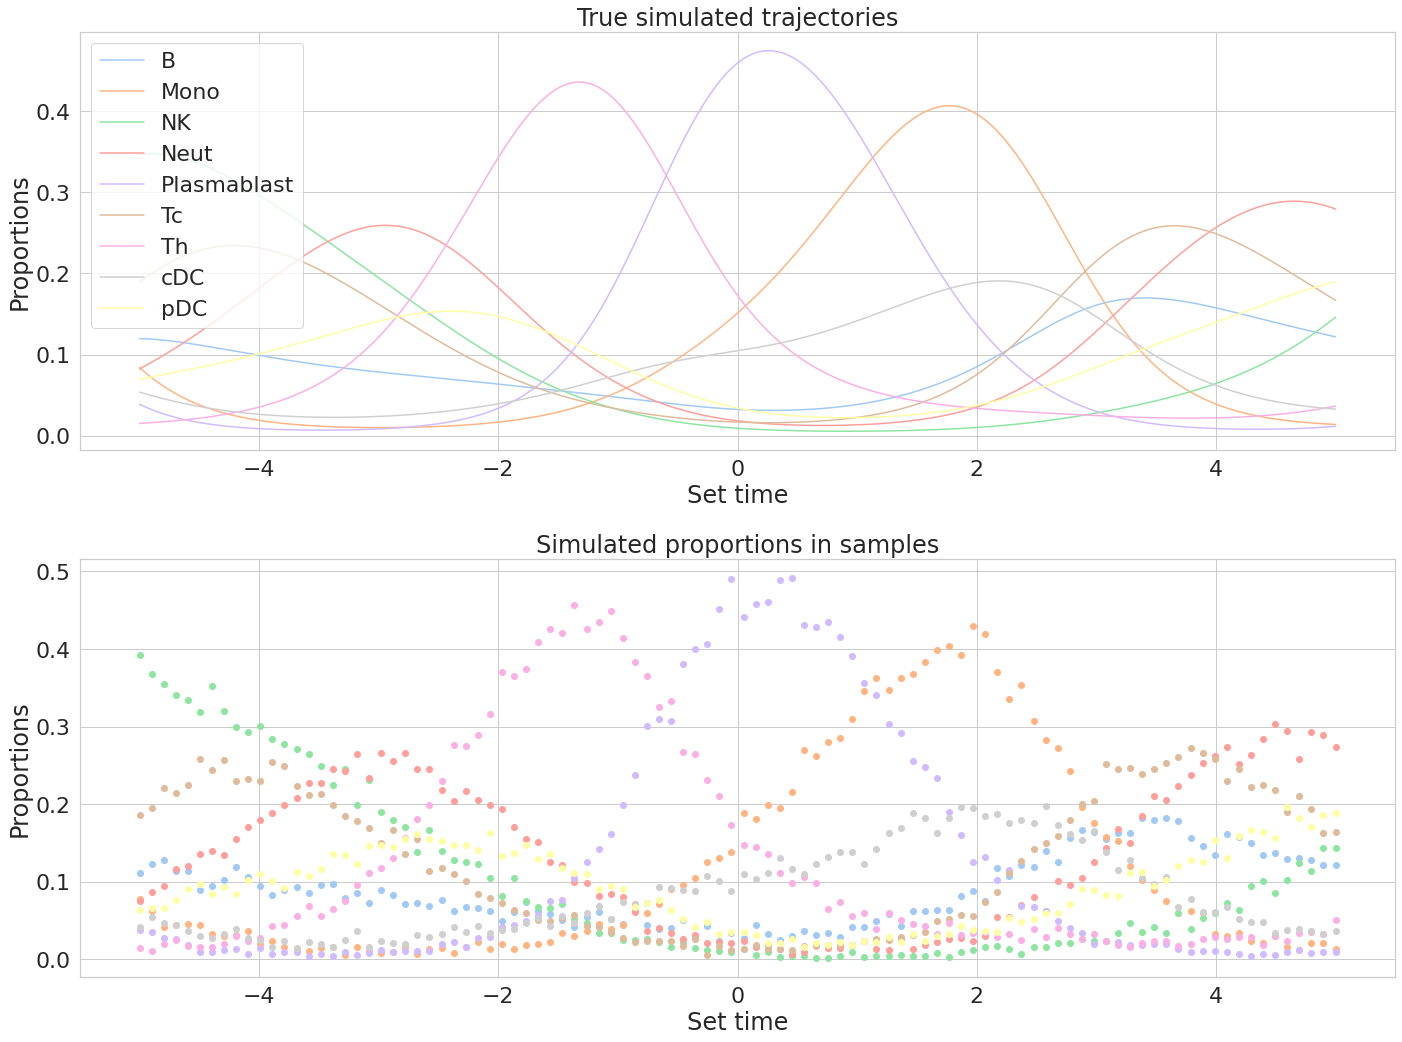

In [55]:
plot_simulated_proportions(sim_res, ebov_sc_dataset, figsize=(20,15))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [10]:
datatype_param = DeconvolutionDatatypeParametrization()

In [11]:
def iter1(n, replicate):
    pyro.clear_param_store()
    
    print(f'Processing with {n} samples')
    sim_res = simulate_data(
        w_hat_gc = torch.Tensor(ebov_sc_dataset.w_hat_gc),
        trajectory_type=trajectory_type,
        num_samples=n, 
        trajectory_coef=trajectory_coef)
    
    # plot the simulated data for this iteration
    plot_simulated_proportions(sim_res, ebov_sc_dataset)
    
    simulated_bulk = generate_anndata_from_sim(
        sim_res, 
        sc_dataset=ebov_sc_dataset)
    
    # Make a deconvolution dataset
    ebov_simulated_dataset = DeconvolutionDataset(
        types=datatype_param,
        parametrization = DeconvolutionDatasetParametrization(
            sc_anndata = sc_anndata,
            sc_celltype_col = "Subclustering_reduced",
            bulk_anndata = simulated_bulk,
            bulk_time_col = "time",
        )       
    )
    
    # Deconvolve
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
        dataset=ebov_simulated_dataset,
        trajectory_model_type='gp',
        hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
        trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
        types=datatype_param)
    pseudo_time_reg_deconv_sim.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000,keep_param_store_history=False)
    
    # Plot the trajectory
    plotter = DeconvolutionPlotter(pseudo_time_reg_deconv_sim)
    plotter.plot_composition_trajectories()
    
    # Calculate trajectory error
    errors = calculate_trajectory_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    df_n.append(n)
    df_rep.append(replicate)
    l1_error.append(errors['L1_error_norm'])

In [12]:
n_samples = [100, 50, 25, 20, 15, 10, 5]

Processing with 100 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.367e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2919 genes selected
[step: 0, time: 1 s ] loss: 4124069.85
[step: 1000, time: 29 s ] loss: 2342443.28
[step: 2000, time: 58 s ] loss: 1767735.99
[step: 3000, time: 87 s ] loss: 1557056.74
[step: 4000, time: 115 s ] loss: 1477251.34
Processing with 100 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.42688e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2824 genes selected
[step: 0, time: 1 s ] loss: 3899395.04
[step: 1000, time: 29 s ] loss: 2275087.42
[step: 2000, time: 58 s ] loss: 1732586.21
[step: 3000, time: 87 s ] loss: 1518141.49
[step: 4000, time: 116 s ] loss: 1438217.32
Processing with 100 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.23086e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2867 genes selected
[step: 0, time: 1 s ] loss: 3991539.97
[step: 1000, time: 29 s ] loss: 2334674.85
[step: 2000, time: 58 s ] loss: 1758767.94
[step: 3000, time: 86 s ] loss: 1542320.08
[step: 4000, time: 115 s ] loss: 1462591.23
Processing with 50 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.36327e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2868 genes selected
[step: 0, time: 1 s ] loss: 1928906.13
[step: 1000, time: 24 s ] loss: 1156380.66
[step: 2000, time: 47 s ] loss: 871757.55
[step: 3000, time: 71 s ] loss: 773245.27
[step: 4000, time: 94 s ] loss: 731472.05
Processing with 50 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.22021e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2948 genes selected
[step: 0, time: 1 s ] loss: 2023222.26
[step: 1000, time: 24 s ] loss: 1226160.41
[step: 2000, time: 48 s ] loss: 906642.12
[step: 3000, time: 72 s ] loss: 796560.56
[step: 4000, time: 95 s ] loss: 757686.45
Processing with 50 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.29864e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2871 genes selected
[step: 0, time: 1 s ] loss: 2026749.66
[step: 1000, time: 24 s ] loss: 1183093.58
[step: 2000, time: 46 s ] loss: 880193.87
[step: 3000, time: 70 s ] loss: 777765.75
[step: 4000, time: 93 s ] loss: 739350.50
Processing with 25 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.21621e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2991 genes selected
[step: 0, time: 1 s ] loss: 983953.07
[step: 1000, time: 15 s ] loss: 610545.92
[step: 2000, time: 30 s ] loss: 464220.65
[step: 3000, time: 44 s ] loss: 411063.50
[step: 4000, time: 59 s ] loss: 392227.00
Processing with 25 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.08699e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2976 genes selected
[step: 0, time: 1 s ] loss: 1071424.01
[step: 1000, time: 15 s ] loss: 614523.98
[step: 2000, time: 30 s ] loss: 467338.67
[step: 3000, time: 45 s ] loss: 410944.39
[step: 4000, time: 59 s ] loss: 392182.17
Processing with 25 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.33001e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2965 genes selected
[step: 0, time: 1 s ] loss: 1098911.74
[step: 1000, time: 15 s ] loss: 593856.64
[step: 2000, time: 30 s ] loss: 448204.25
[step: 3000, time: 45 s ] loss: 400911.00
[step: 4000, time: 60 s ] loss: 383811.31
Processing with 20 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.56263e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2839 genes selected
[step: 0, time: 1 s ] loss: 806861.55
[step: 1000, time: 15 s ] loss: 458119.80
[step: 2000, time: 29 s ] loss: 355246.28
[step: 3000, time: 43 s ] loss: 314444.12
[step: 4000, time: 58 s ] loss: 300896.56
Processing with 20 samples


/mnt/disk2/nbarkas/deconvolution_method/temporal-rna-seq-deconvolution/ternadecov/simulator.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = matplotlib.pyplot.subplots(
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.50811e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2936 genes selected
[step: 0, time: 1 s ] loss: 775087.92
[step: 1000, time: 15 s ] loss: 458660.92
[step: 2000, time: 29 s ] loss: 360204.17
[step: 3000, time: 43 s ] loss: 319864.58
[step: 4000, time: 58 s ] loss: 307268.28
Processing with 20 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57991e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2824 genes selected
[step: 0, time: 1 s ] loss: 824162.26
[step: 1000, time: 15 s ] loss: 451653.73
[step: 2000, time: 29 s ] loss: 346159.00
[step: 3000, time: 43 s ] loss: 308643.38
[step: 4000, time: 57 s ] loss: 295776.84
Processing with 15 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.01625e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2990 genes selected
[step: 0, time: 1 s ] loss: 698541.33
[step: 1000, time: 14 s ] loss: 365741.77
[step: 2000, time: 27 s ] loss: 285690.20
[step: 3000, time: 40 s ] loss: 255613.15
[step: 4000, time: 53 s ] loss: 244066.34
Processing with 15 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.35968e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2964 genes selected
[step: 0, time: 1 s ] loss: 603352.93
[step: 1000, time: 14 s ] loss: 355769.10
[step: 2000, time: 27 s ] loss: 279059.58
[step: 3000, time: 40 s ] loss: 248969.06
[step: 4000, time: 53 s ] loss: 238842.91
Processing with 15 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.16431e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2969 genes selected
[step: 0, time: 1 s ] loss: 644352.21
[step: 1000, time: 14 s ] loss: 390051.65
[step: 2000, time: 27 s ] loss: 279929.20
[step: 3000, time: 40 s ] loss: 251544.39
[step: 4000, time: 53 s ] loss: 241428.15
Processing with 10 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.3292e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


3011 genes selected
[step: 0, time: 1 s ] loss: 377011.35
[step: 1000, time: 13 s ] loss: 236245.76
[step: 2000, time: 26 s ] loss: 189793.54
[step: 3000, time: 39 s ] loss: 169349.11
[step: 4000, time: 52 s ] loss: 164839.69
Processing with 10 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.35094e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2978 genes selected
[step: 0, time: 1 s ] loss: 404402.79
[step: 1000, time: 14 s ] loss: 246136.09
[step: 2000, time: 28 s ] loss: 190310.10
[step: 3000, time: 42 s ] loss: 172066.35
[step: 4000, time: 55 s ] loss: 164686.16
Processing with 10 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.16184e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2995 genes selected
[step: 0, time: 1 s ] loss: 397528.73
[step: 1000, time: 13 s ] loss: 256969.15
[step: 2000, time: 27 s ] loss: 192797.27
[step: 3000, time: 39 s ] loss: 174023.16
[step: 4000, time: 53 s ] loss: 166312.12
Processing with 5 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.84889e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


3226 genes selected
[step: 0, time: 1 s ] loss: 217679.78
[step: 1000, time: 12 s ] loss: 144553.32
[step: 2000, time: 23 s ] loss: 112543.35
[step: 3000, time: 35 s ] loss: 98110.49
[step: 4000, time: 46 s ] loss: 94902.69
Processing with 5 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.98818e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


3150 genes selected
[step: 0, time: 1 s ] loss: 257228.07
[step: 1000, time: 12 s ] loss: 146414.63
[step: 2000, time: 23 s ] loss: 110141.24
[step: 3000, time: 35 s ] loss: 97184.90
[step: 4000, time: 46 s ] loss: 94245.14
Processing with 5 samples


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.68823e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


3210 genes selected
[step: 0, time: 1 s ] loss: 210885.75
[step: 1000, time: 12 s ] loss: 138175.51
[step: 2000, time: 24 s ] loss: 111957.63
[step: 3000, time: 35 s ] loss: 100215.62
[step: 4000, time: 47 s ] loss: 96840.89


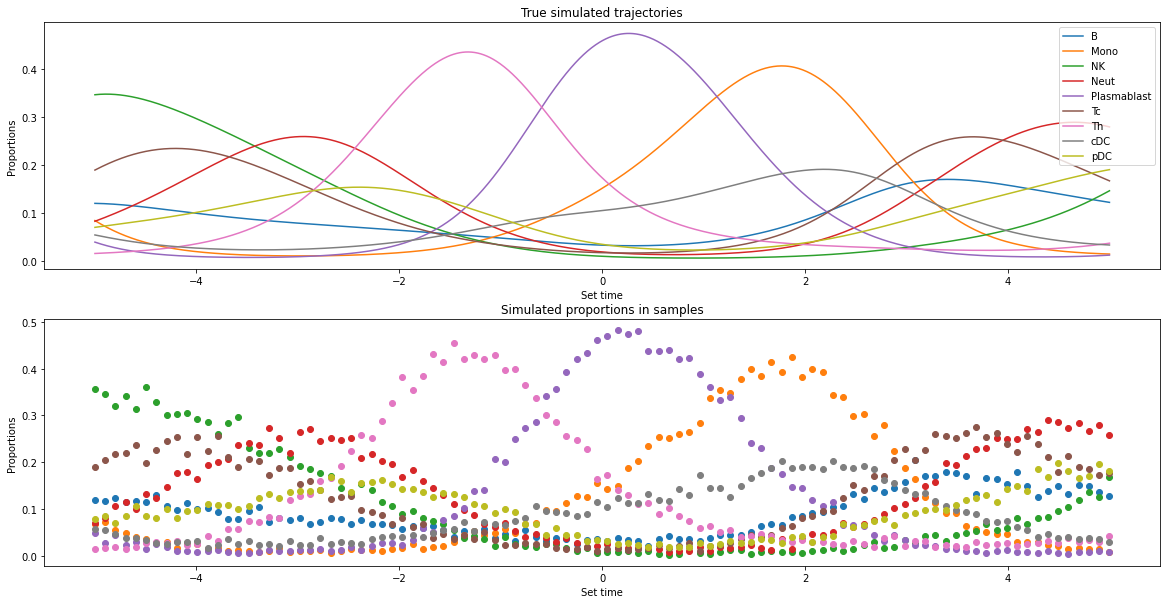

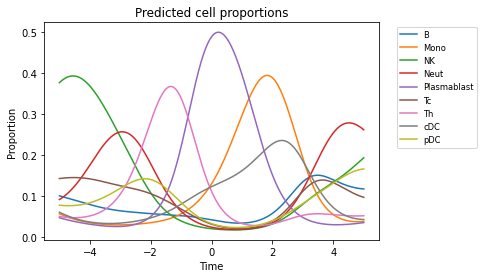

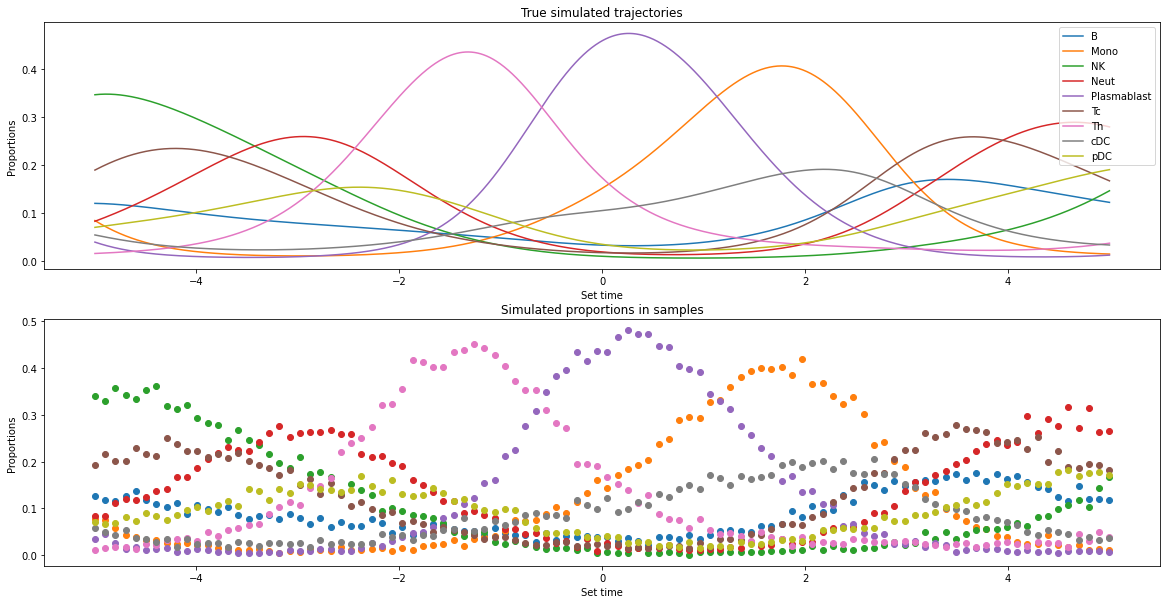

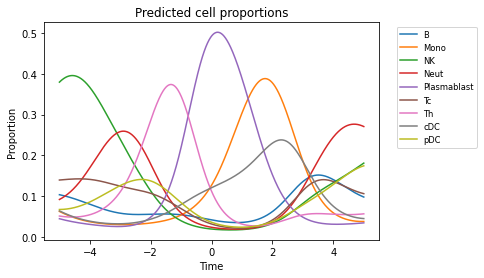

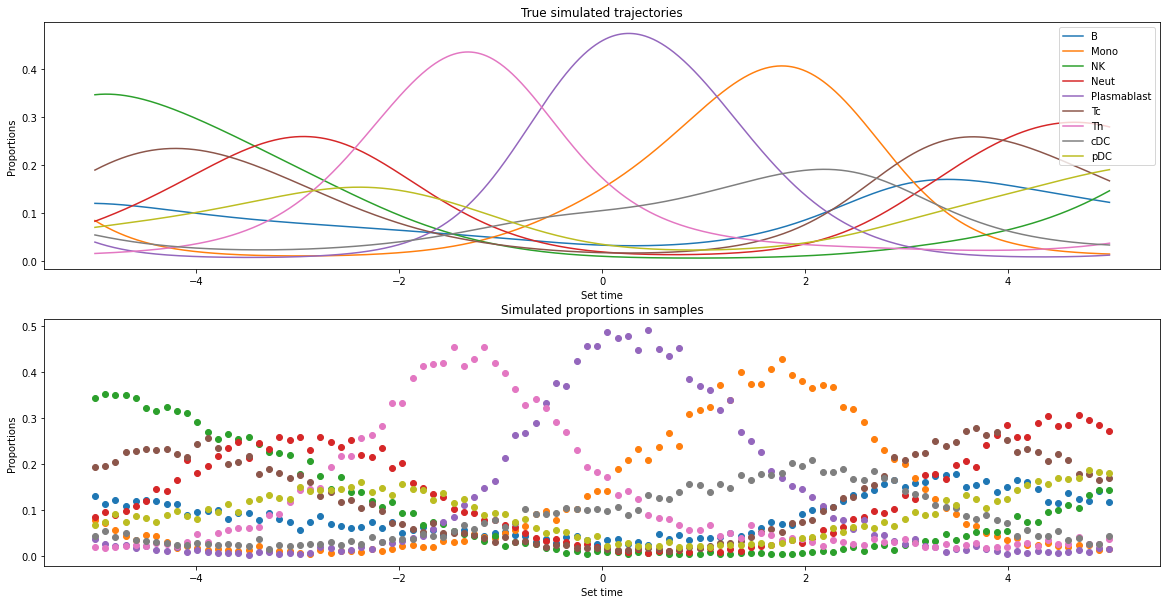

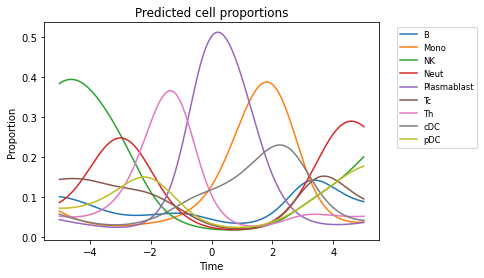

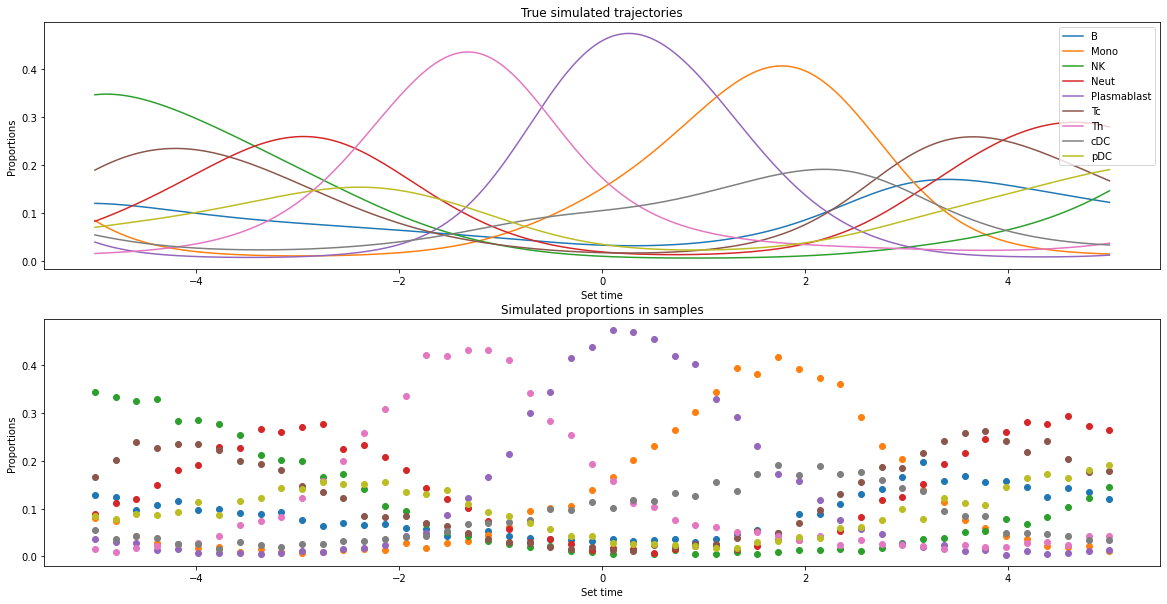

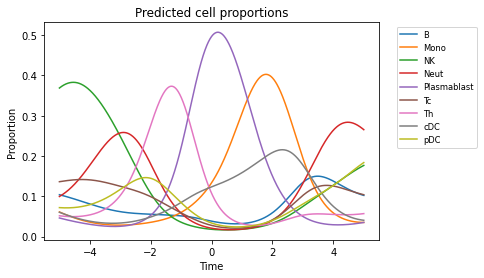

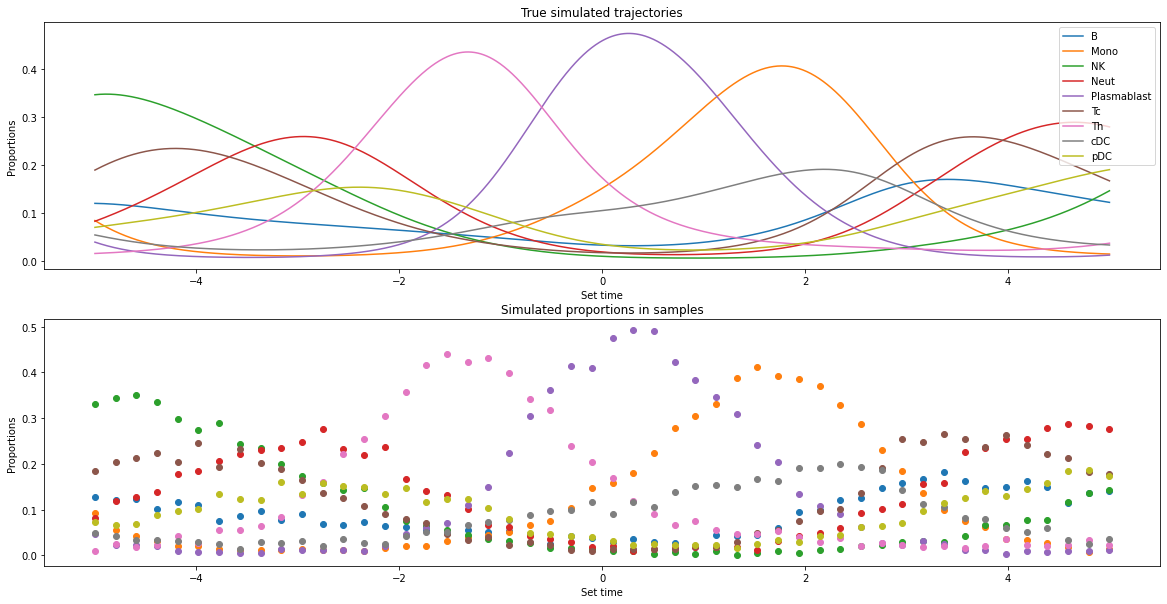

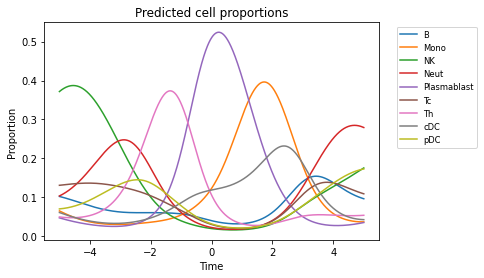

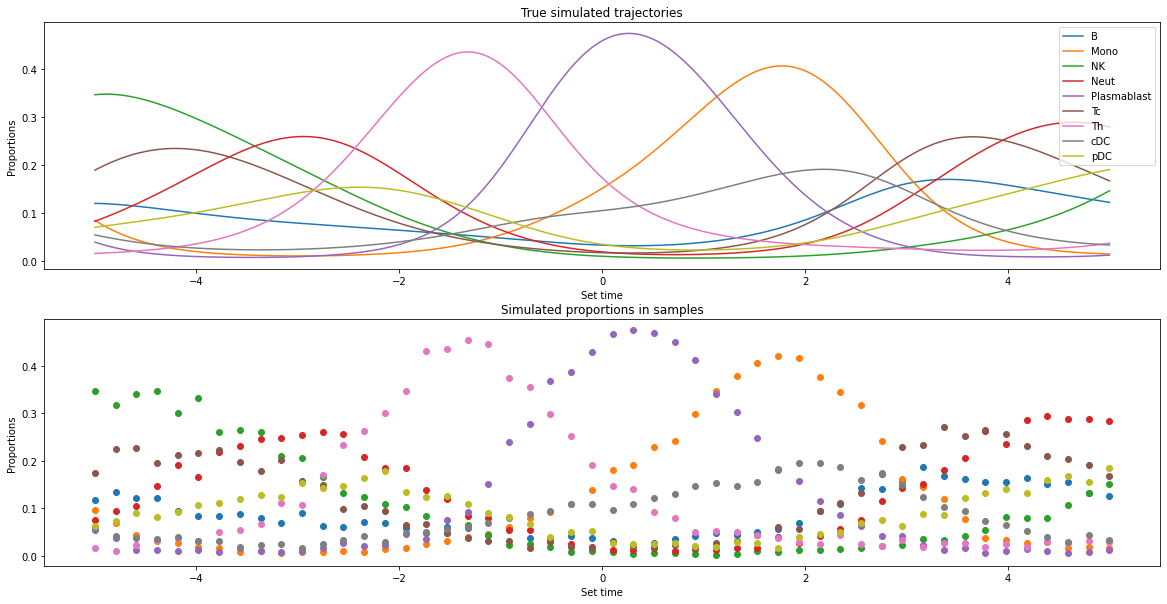

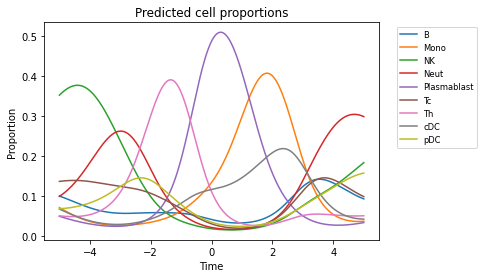

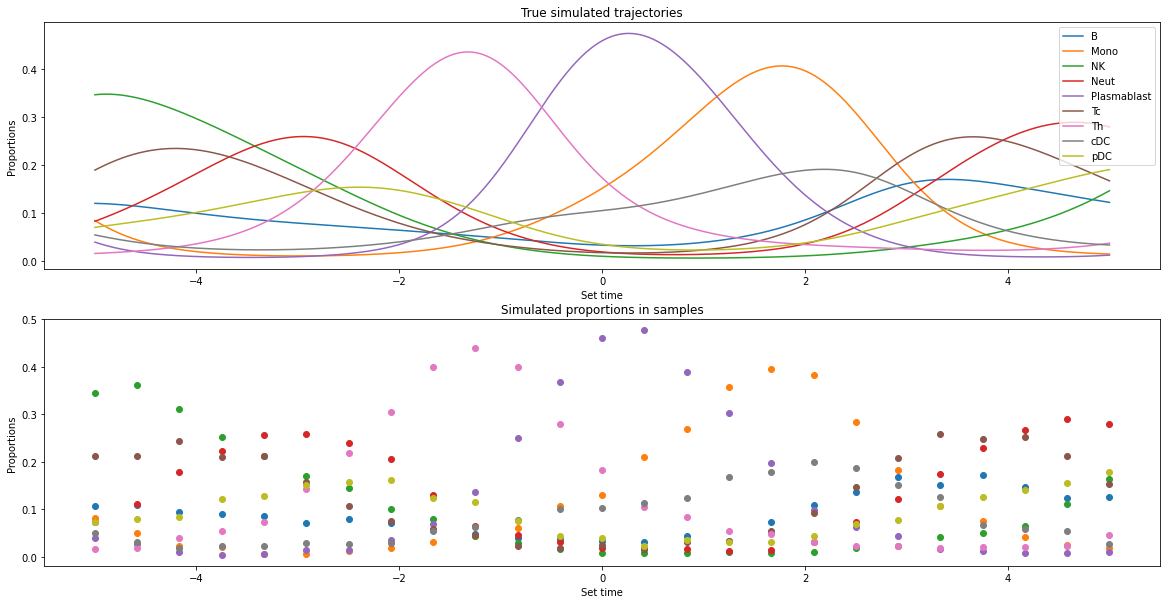

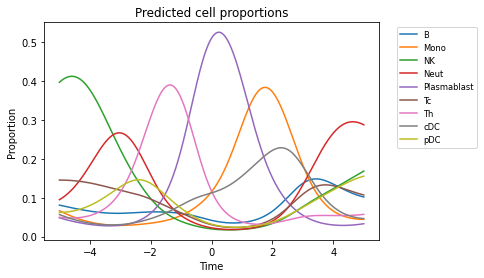

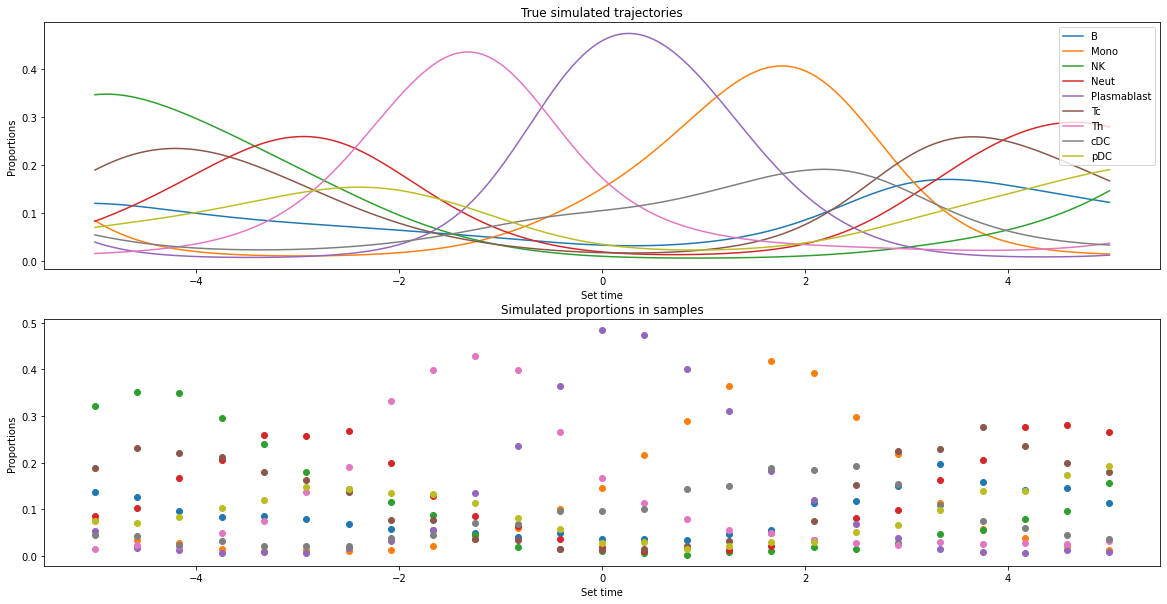

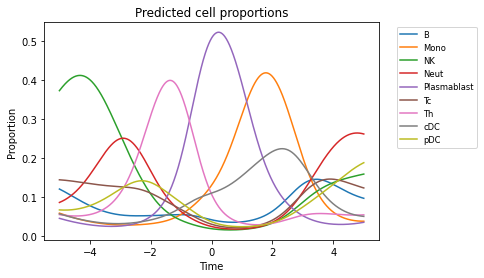

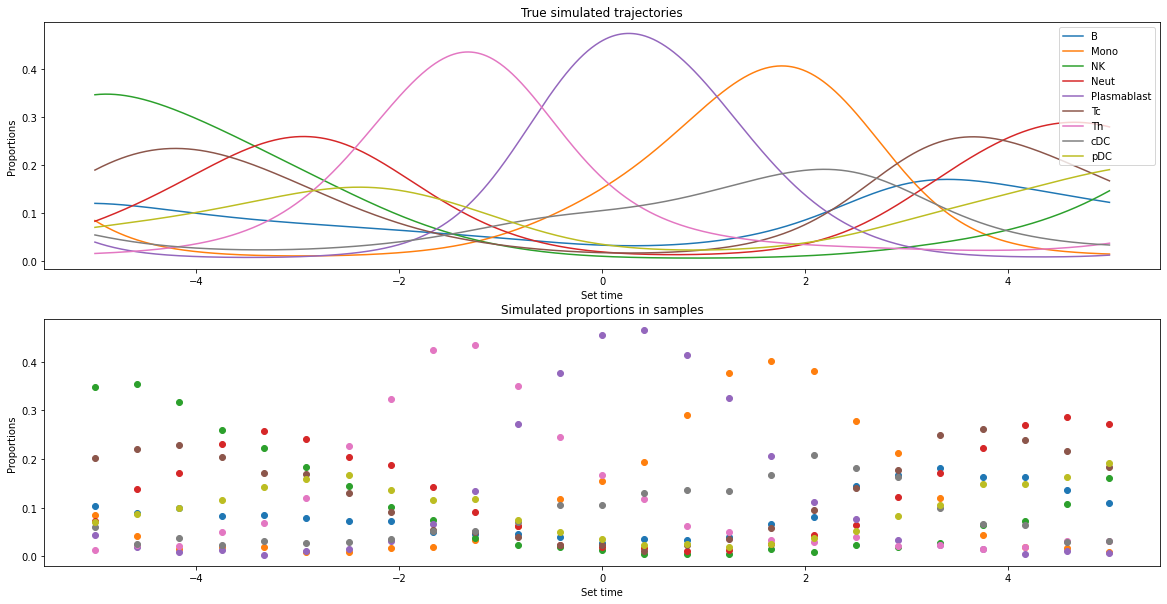

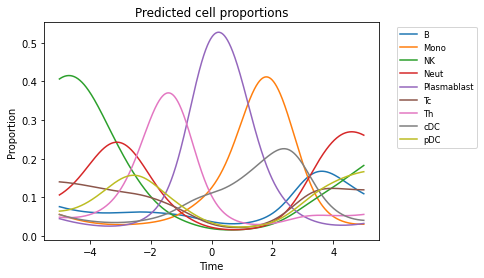

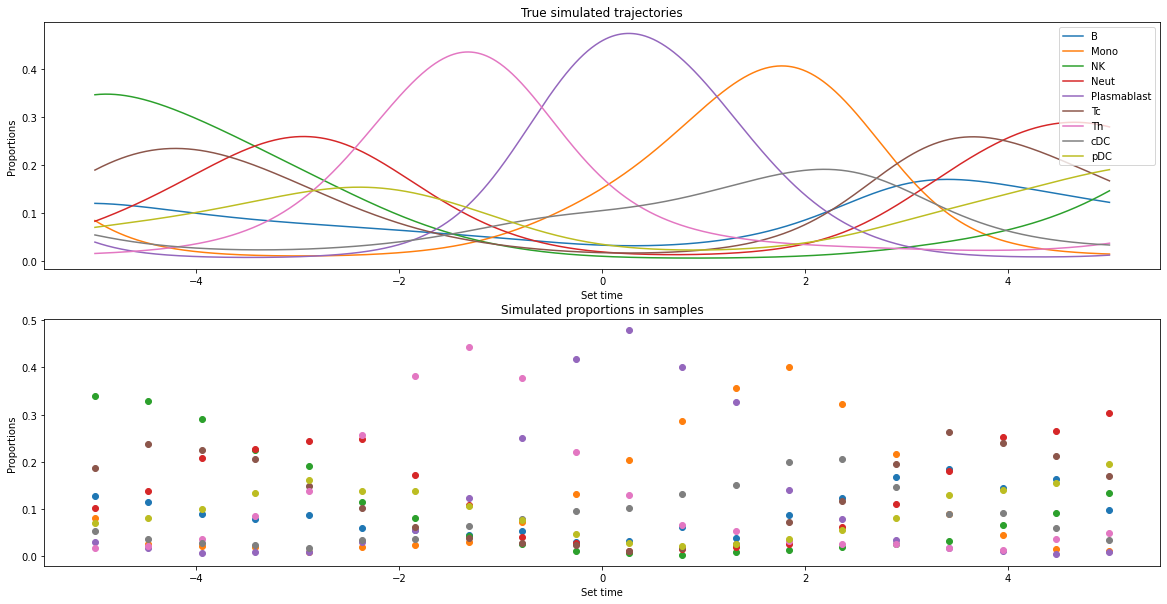

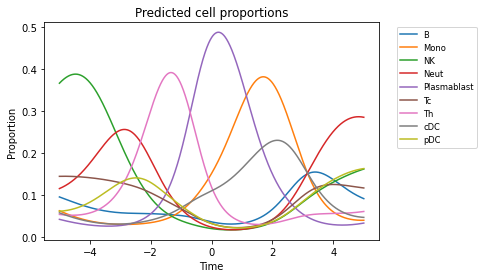

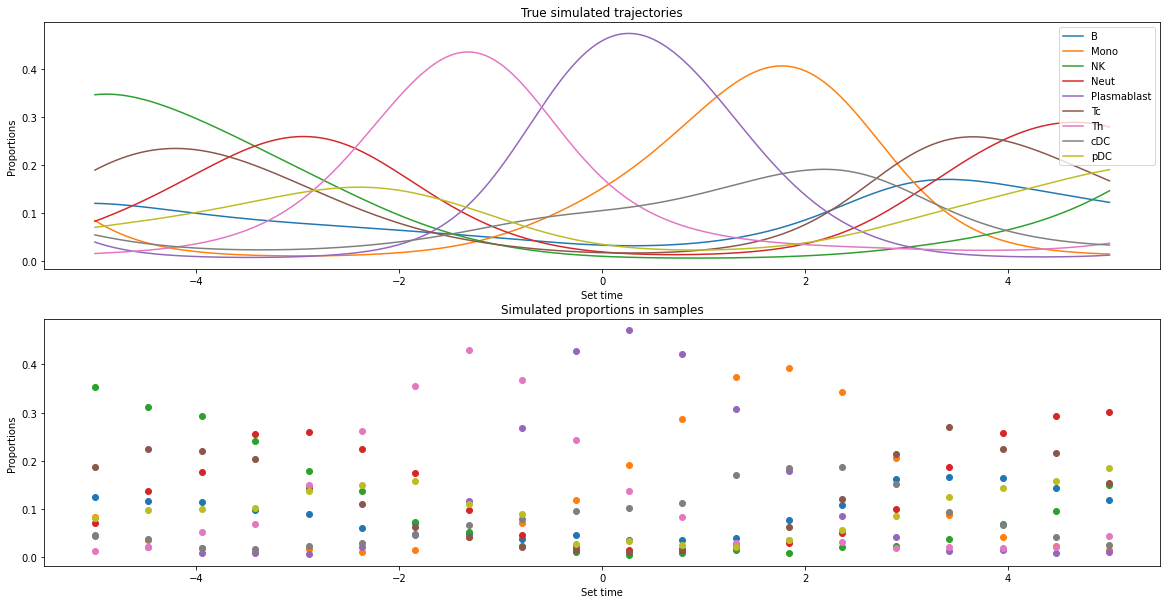

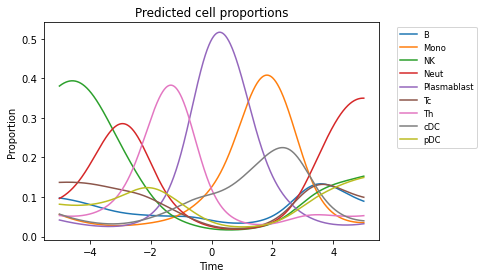

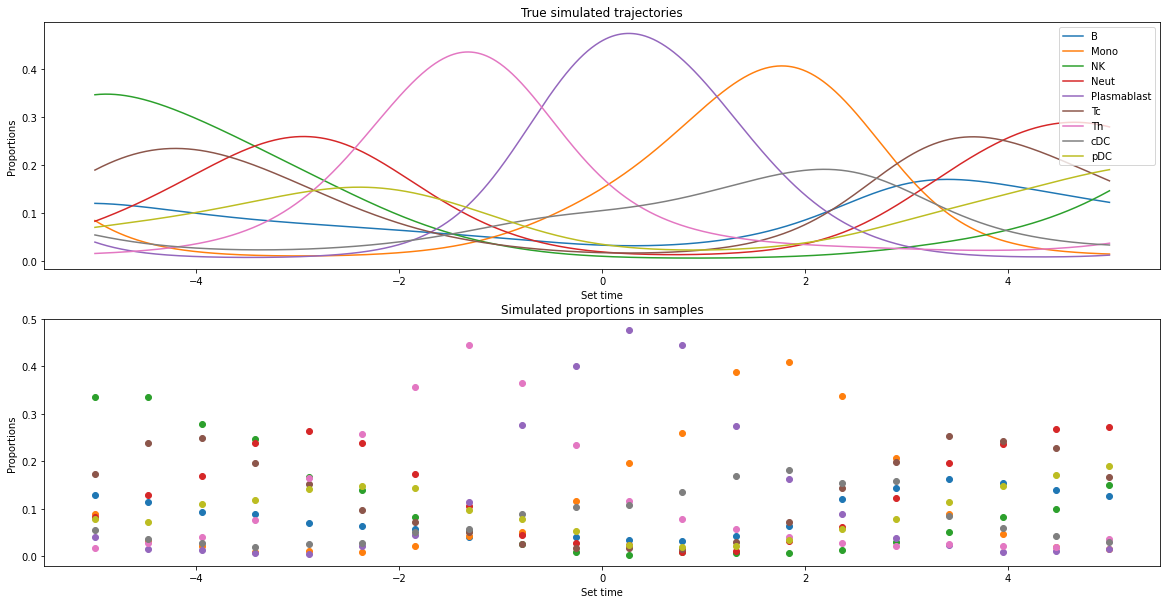

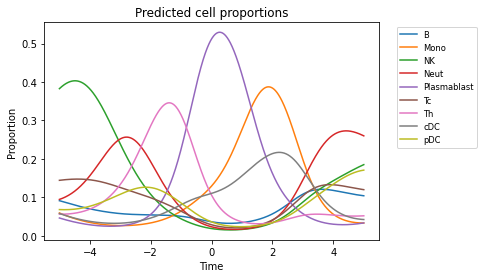

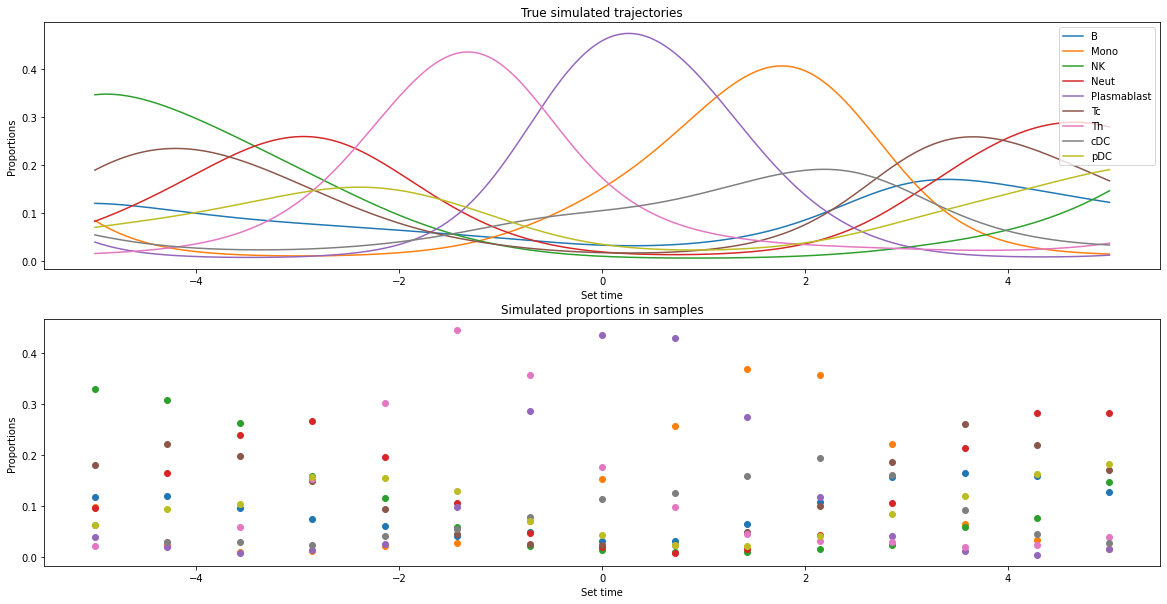

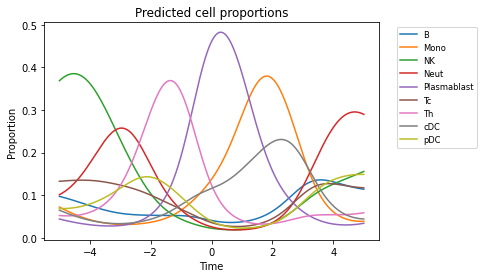

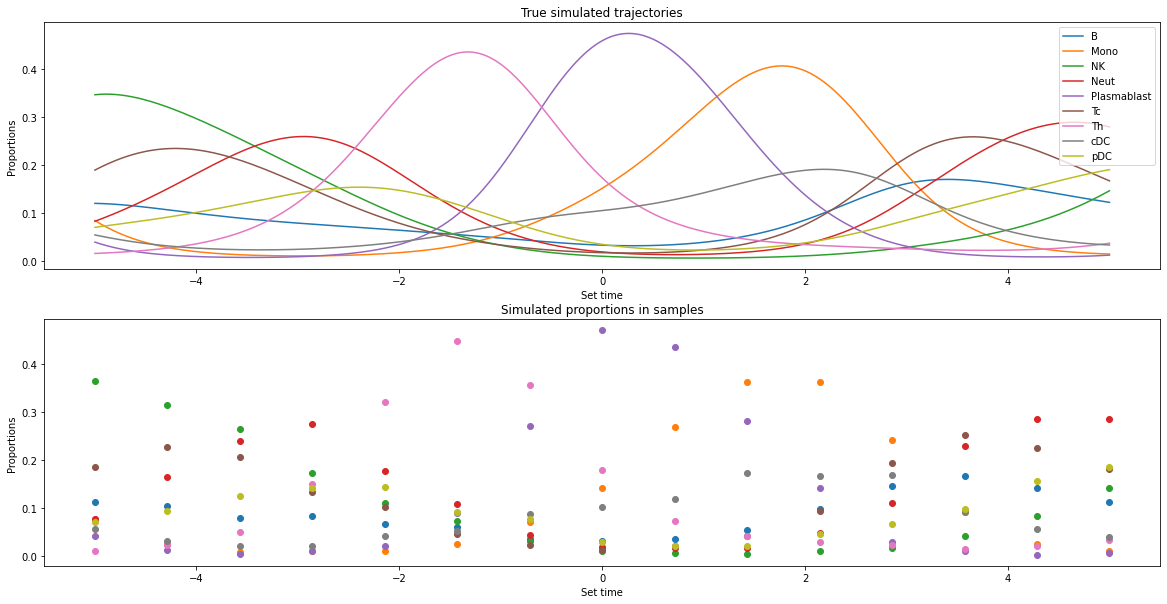

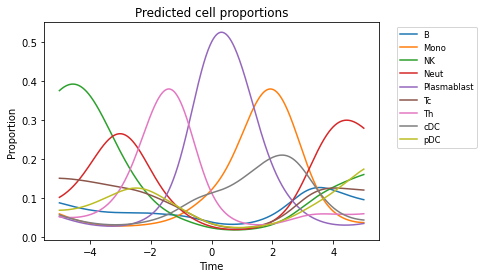

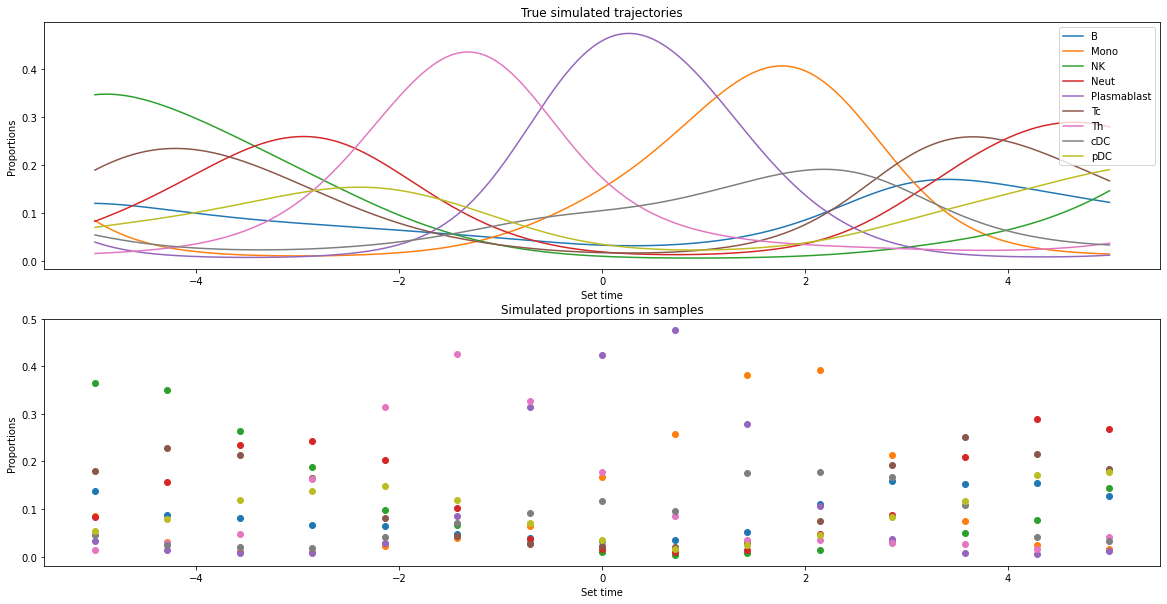

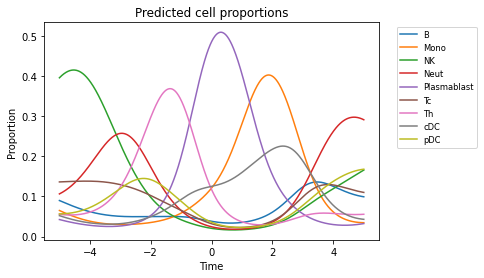

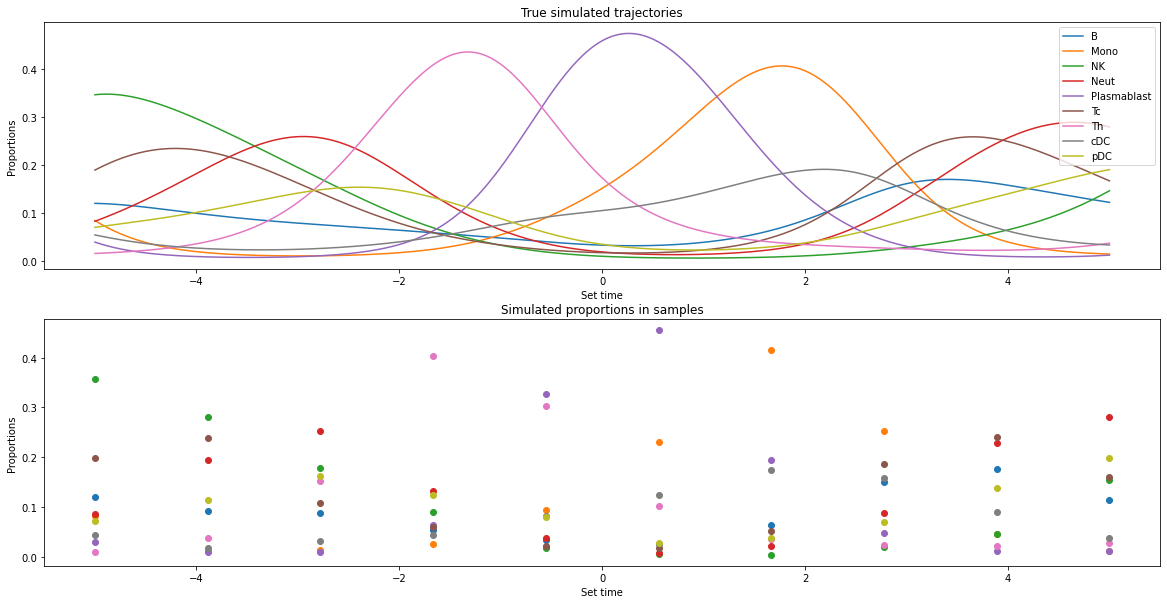

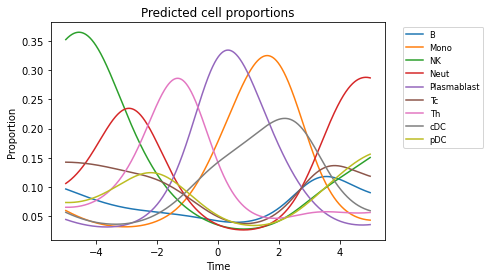

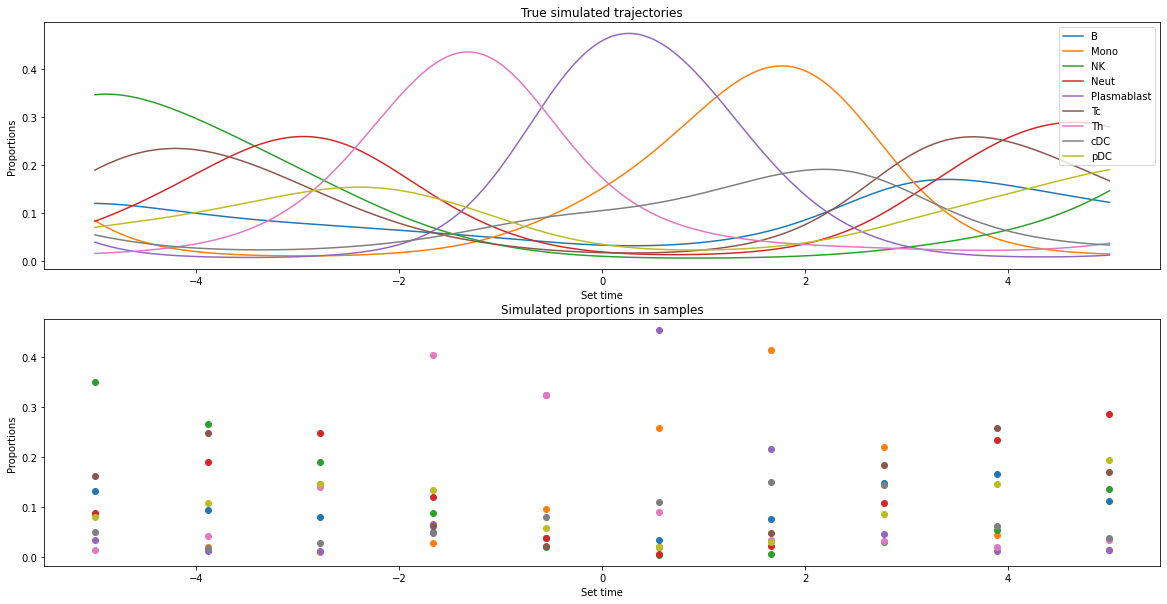

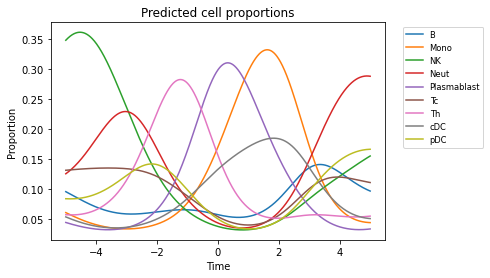

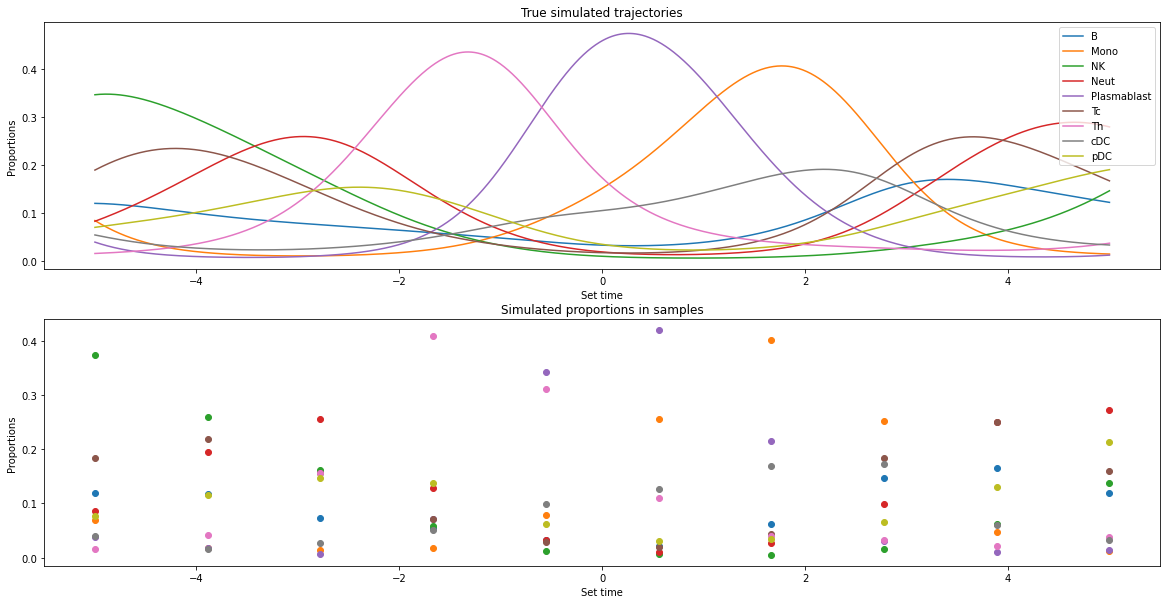

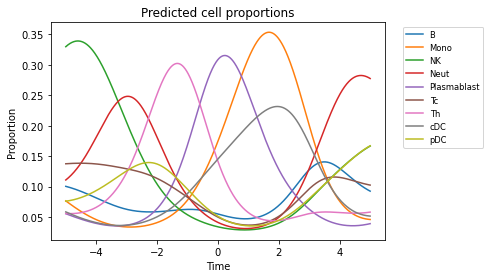

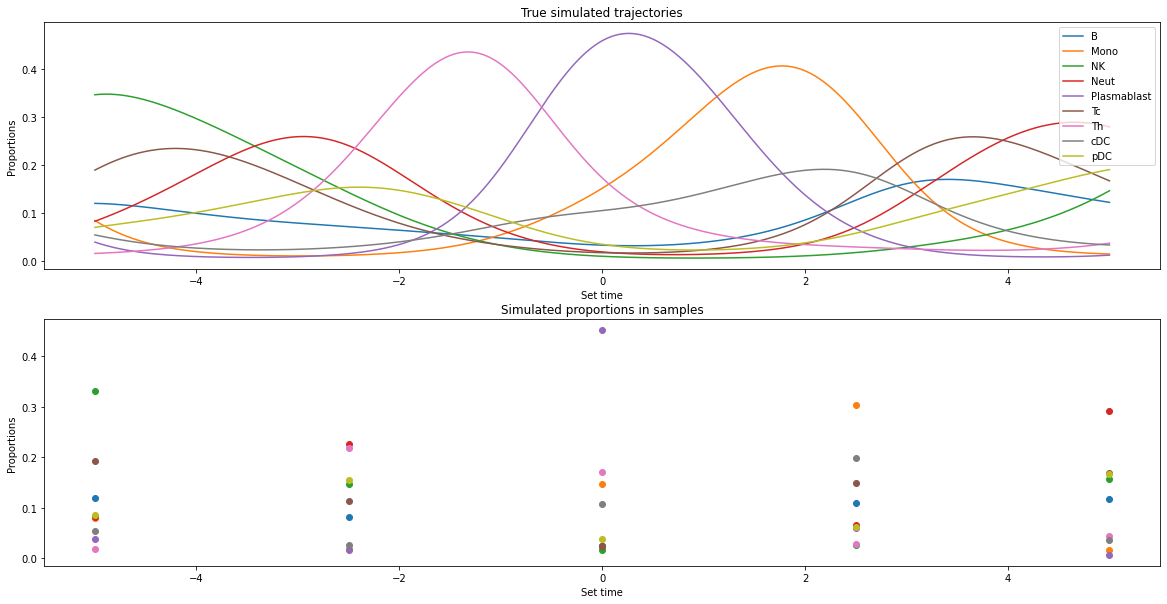

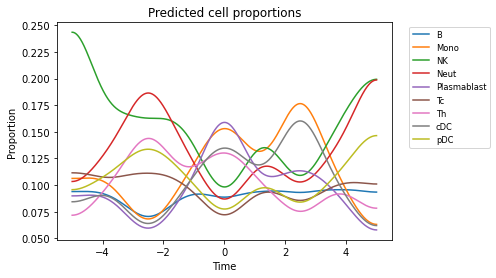

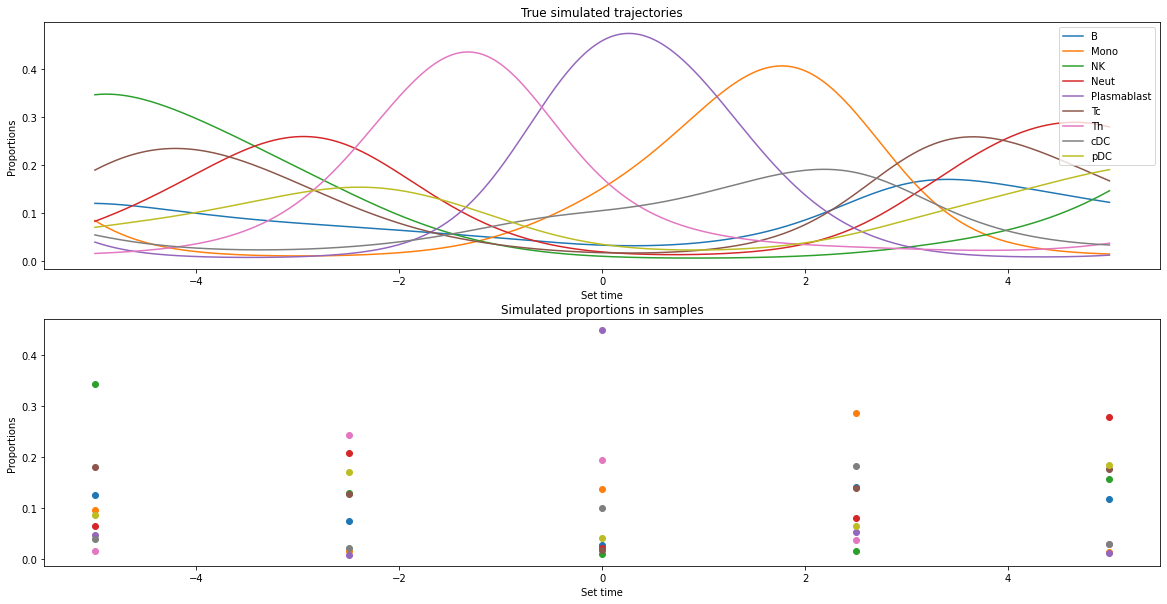

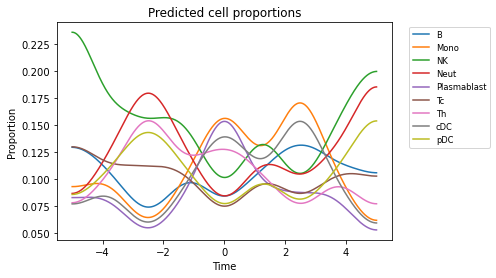

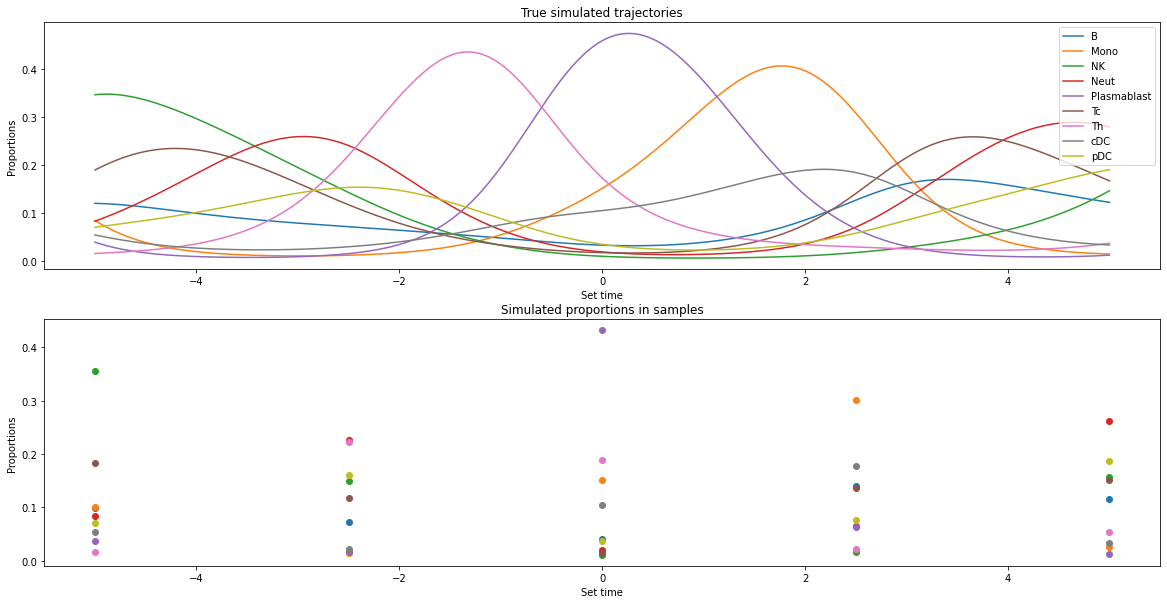

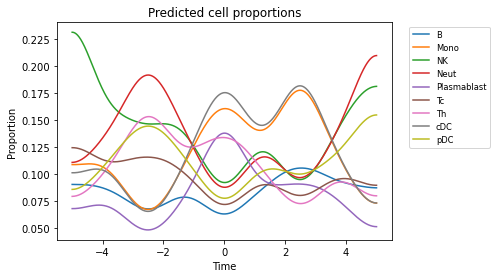

In [14]:
df_n = []
df_rep = []
l1_error = []

for n in n_samples:
    for r in range(3):
        iter1(n,r)

In [16]:
import seaborn as sns

In [18]:
# Plot L1 loss
error_df = pd.DataFrame({'n':df_n, 'l1_norm': list(x.item() for x in l1_error)})
#error_df.plot(x='n',y='l1_norm')

In [21]:
error_df.head()

n   l1_norm
0  100  0.201018
1  100  0.201328
2  100  0.206972
3   50  0.197089
4   50  0.198752

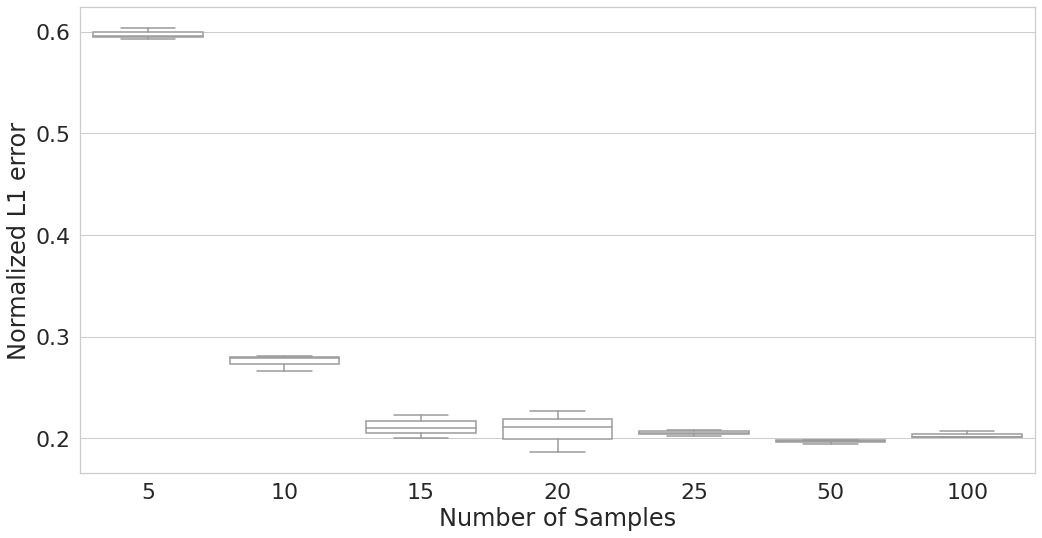

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid", palette="pastel",font_scale = 2)

sns.boxplot(data=error_df, x='n', y='l1_norm', color='white')
matplotlib.pyplot.ylabel('Normalized L1 error')
matplotlib.pyplot.xlabel('Number of Samples')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [24]:
error_df.to_csv('increasing_n_evaluation_results.csv')